# ** Описание **

In [23]:
from __future__ import division
from __future__ import unicode_literals

import base64
import csv
import gzip
import zlib
import pymorphy2
import nltk
import string
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import namedtuple
from collections import defaultdict

from math import log
from math import exp

%matplotlib inline
import matplotlib.pyplot as plt

In [24]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [25]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [26]:
from HTMLParser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = []
        self._anchor = []
        self._in_title = False
        self._in_anchor = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            if self._in_title == True:
                self._title.append(text + ' ')
                self._in_title = False
            elif self._in_anchor == True:
                self._anchor.append(text + ' ')
                self._in_anchor = False
            else:
                self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True
        elif tag == 'a':
            self._in_anchor = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()
    
    def title(self):
        return ''.join(self._title).strip()
    
    def anchor(self):
        return ''.join(self._anchor).strip()

@convert2unicode
# @to_utf8
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    data = []
    data.append(parser.text().encode('utf8'))
    data.append(parser.title().encode('utf8'))
    data.append(parser.anchor().encode('utf8'))
    return data

#### Извлечение текста при помощи дополнительных библиотек

In [27]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [28]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [29]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
nltk.download('stopwords')
nltk.download('punkt')
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

def tokenize_me(file_text):
    #firstly let's apply nltk tokenization
    tokens = nltk.word_tokenize(file_text)
     
    #cleaning words
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]
    tokens = [i for i in tokens if (not i.encode('utf-8').isdigit())]
 
    #let's delete punctuation symbols
    tokens = [i for i in tokens if ( i not in string.punctuation )]
 
    #deleting stop_words
    stop_words = stopwords.words("russian")
    stop_words.extend(["что", "это", "так", "вот", "быть", "как", "в", "—", "к", "на"])
    tokens = [i for i in tokens if ( i not in stop_words )]
    stop_words = stopwords.words("english")
    stop_words.extend(["login", "form", "menu", "js", "fn", "csript", "topic", "l", "r"])
    tokens = [i for i in tokens if ( i not in stop_words )]


    #stemming words
    stemmer = nltk.stem.SnowballStemmer("russian")
    tokens = [stemmer.stem(i) for i in tokens]
    stemmer = nltk.stem.SnowballStemmer("english")
    tokens = [stemmer.stem(i) for i in tokens]
 
    return tokens

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE

    tokenized = tokenize_me(text)
    for word in tokenized:
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Alex_Reznikova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Alex_Reznikova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Основная функция, которая вызывается для преобразования html в список слов

In [30]:
def html2word(raw_html, to_text=html2text, tokenizer=pymorphy_tokenizer):
    return tokenizer(to_text(raw_html)[0].lower()), tokenizer(to_text(raw_html)[1].lower()), tokenizer(to_text(raw_html)[2].lower())

#### Рассчет финальных метрик

In [31]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print 'threshold %s' % threshold
            print '\tclass_prec %s, class_recall %s, class_F1 %s' % r[0]
            print '\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1]
            print '\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2)
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [32]:
def calc_features(url, html_data):
    freq_ = {}
    data = html2word(html_data)
#     data_raw = html2word(html_data, tokenizer=easy)
    words = list(data[0])
    words_enc = " ".join(words).encode('utf-8')
    words_num = len(words)
    
    titles = list(data[1])
    titles_enc = " ".join(titles).encode('utf-8')
    title_words_num = len(titles)
    
    anchors = list(data[2])
    anchors_enc = " ".join(anchors).encode('utf-8')
    anchor_words_num = len(anchors)
    
    all_words_num = words_num + title_words_num + anchor_words_num
    
    if words_num != 0:
        vect = TfidfVectorizer()
        tfidf_matrix = vect.fit_transform([words_enc, titles_enc, anchors_enc])
        df = pd.DataFrame(tfidf_matrix.toarray(), columns = vect.get_feature_names())
        voc = np.array(df.mean(axis=0).sort_values(ascending=False).index)
#         voc = np.array(df.mean(axis=0).sort_values(ascending=False)[:15].index)
        weights = np.array(df.mean(axis=0).sort_values(ascending=False)[:15].values)
        tf_html_feat = np.zeros(voc.shape[0])

        doc = words + titles + anchors
        for j, word in enumerate(voc):
            wc = doc.count(word)
            if wc == 0:
                wc = 1
            tf_html_feat[j] = wc
            freq_[word] = wc

        temp = tf_html_feat[:15] * weights
        tf_html_feat_m = temp.sum()
        compression_level_w = len(zlib.compress(html_data)) / len(html_data)
        avg_word_len = sum([len(w) for w in words]) / words_num
    else:
        compression_level_w = 0
        tf_html_feat_m = 0
        avg_word_len = 0
    
    if anchor_words_num != 0:
        vect = TfidfVectorizer()
        tfidf_matrix = vect.fit_transform([anchors_enc])
        df = pd.DataFrame(tfidf_matrix.toarray(), columns = vect.get_feature_names())
        voc = np.array(df.mean(axis=0).sort_values(ascending=False)[:anchor_words_num].index)
        weights = np.array(df.mean(axis=0).sort_values(ascending=False)[:10].values)
        tf_feat = np.zeros(weights.shape[0])

        doc = words + titles
        for j, anchor in enumerate(voc[:10]):
            ac = doc.count(anchor)
            if ac == 0:
                ac = 1
            tf_feat[j] = ac
        
        temp = tf_feat * weights
        tf_feat_m = temp.sum()
        tf_diff = voc.shape[0] / anchor_words_num

    else:
        tf_feat_m = 0
        tf_diff = 0

    return [words_num, avg_word_len, title_words_num,
            anchor_words_num, compression_level_w,
            all_words_num, tf_html_feat_m, tf_feat_m, tf_diff,
            freq_]

In [33]:
test_html_data = u'''
<html>
<title> Заголовок что Заголовка Ololo1 </title>
ololo спам спама 1 2 3 ololo running_bad
<a> lala ololo ololo 111 qqqqq</a>
</html>
'''
#Заголовок
#спам
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print test_features
# print freq

In [34]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 4

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)            
            res_queue.put(DocItem(url_id, mark, url, features))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in xrange(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [35]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'
# TRAIN_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

train_docs = list(load_csv_multiprocess(TRAIN_DATA_FILE, calc_features))

10:50:02 INFO:Complete items 00000 in worker_id 1
10:50:02 INFO:Complete items 00000 in worker_id 0
10:50:02 INFO:Complete items 00000 in worker_id 2
10:50:02 INFO:Complete items 00000 in worker_id 3
10:56:43 INFO:Complete items 01000 in worker_id 1
10:58:04 INFO:Complete items 01000 in worker_id 3
10:58:22 INFO:Complete items 01000 in worker_id 2
10:59:04 INFO:Complete items 01000 in worker_id 0
11:01:59 INFO:Complete items 02000 in worker_id 1
11:02:19 INFO:Complete items 02000 in worker_id 3
11:03:09 INFO:Complete items 02000 in worker_id 0
11:03:33 INFO:Complete items 02000 in worker_id 2
11:06:05 INFO:Complete items 03000 in worker_id 1
11:06:59 INFO:Complete items 03000 in worker_id 3
11:07:10 INFO:Complete items 03000 in worker_id 0
11:11:58 INFO:Complete items 04000 in worker_id 1
11:12:06 INFO:Complete items 03000 in worker_id 2
11:12:11 INFO:Complete items 04000 in worker_id 3
11:13:27 INFO:Complete items 04000 in worker_id 0
11:17:29 INFO:Complete items 04000 in worker_id 2


CPU times: user 4.27 s, sys: 926 ms, total: 5.2 s
Wall time: 43min 47s


In [36]:
# with open('train_features_new_tf_new_nb_20191025.csv' , 'w') as fout:
#     writer = csv.writer(fout, delimiter=str('\t'))
#     writer.writerow(['id', 'target', 'url', 'F_words_num', 'F_avg_word_len',
#                      'F_title_words_num', 'F_anchor_words_num',
#                      'F_compression_level_w', 'F_all_words_num',
#                      'F_tf_html_feat_m', 'F_tf_feat_m', 'F_tf_diff'])
#     for item in train_docs:
#         writer.writerow([item[0], item[1], item[2],
#                          item.features[0], item.features[1],
#                          item.features[2], item.features[3],
#                          item.features[4], item.features[5],
#                          item.features[6], item.features[7],
#                          item.features[8]])

In [ ]:
# print train_docs[:2]

In [84]:
# DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

# with open('train_features_new_tf_new_nb_20191025.csv', 'r') as input_file:
#     headers = input_file.readline()
#     train_docs = []

#     for i, line in enumerate(input_file):
#         parts = line.strip().split('\t')
#         url_id = int(parts[0])
#         if parts[1] == 'True':
#             mark = True
#         else:
#             mark = False
#         url = parts[2]
#         words_num = int(parts[3])
#         avg_word_len = float(parts[4])
#         title_words_num = int(parts[5])
#         anchor_words_num = int(parts[6])
#         compression_level_w = float(parts[7])
#         all_words_num = int(parts[8])
#         tf_html_feat_m = float(parts[9])
#         tf_feat_m = float(parts[10])
#         tf_diff = float(parts[11])
#         features = [words_num, avg_word_len, title_words_num, anchor_words_num,
#                     compression_level_w, all_words_num, tf_html_feat_m, tf_feat_m,
#                     tf_diff]
         
#         train_docs.append(DocItem(url_id, mark, url, features))

In [85]:
# print train_docs[:2]

[DocItem(doc_id=-9221399504663603656, is_spam=False, url=u'http://alterhost.ruwww.alterhost.ruwww.user.kz.ru/', features=[507, 7.447731755424063, 1, 153, 0.2559094551282051, 661, 5.224307340676161, 0.6131393394849658, 1.16793893129771]), DocItem(doc_id=-9218561774155397294, is_spam=False, url=u'http://fshops.otzyv.ru/read.php?id=277', features=[726, 5.881542699724518, 3, 105, 0.2344726203601617, 834, 7.673428359919555, 0.52, 1.4])]


In [38]:
len(train_docs)

7044

In [39]:
# return [0 - words_num, 1 - avg_word_len, 2 - title_words_num,
#         3 - anchor_words_num, 4 - compression_level_w,
#         5 - all_words_num, 6 - tf_html_feat_m, 7 - tf_feat_m,
#         8 - tf_diff]

/Users/Alex_Reznikova/anaconda3/envs/anti/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


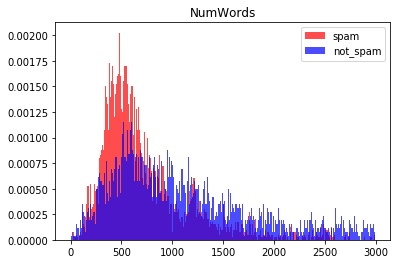

In [40]:
is_spam_data = [doc.features[5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[5] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

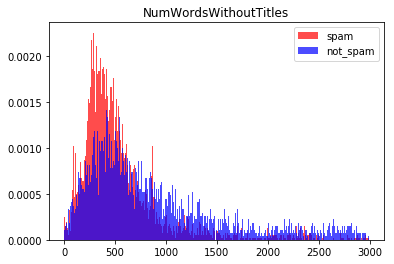

In [41]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsWithoutTitles')
plt.legend()
plt.show()

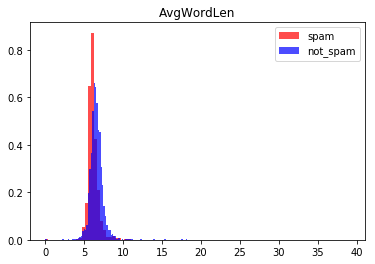

In [42]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

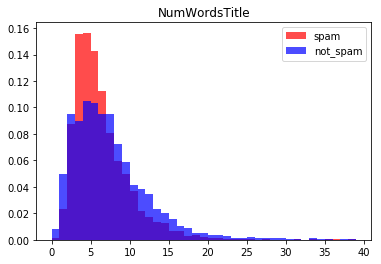

In [43]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 40, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

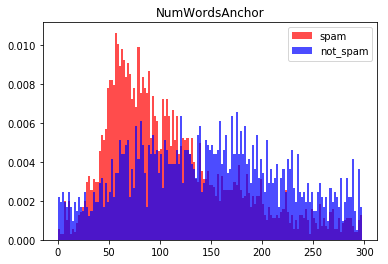

In [44]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 300, 2)
# bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsAnchor')
plt.legend()
plt.show()

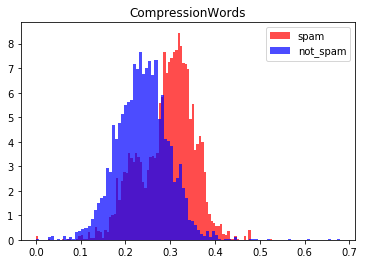

In [45]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
# bins = range(0, 20, 1)
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('CompressionWords')
plt.legend()
plt.show()

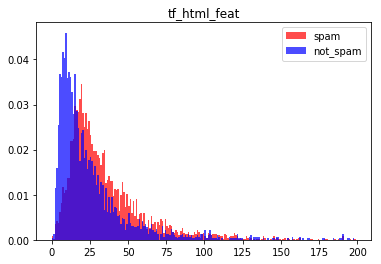

In [46]:
is_spam_data = [doc.features[6] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[6] for doc in train_docs if doc[1] == False]
bins = range(0, 200, 1)
# bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('tf_html_feat')
plt.legend()
plt.show()

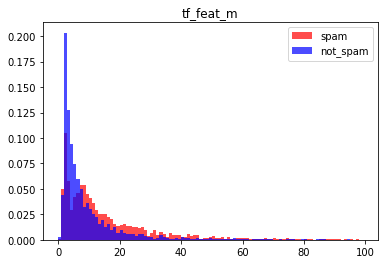

In [47]:
is_spam_data = [doc.features[7] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[7] for doc in train_docs if doc[1] == False]
bins = range(0, 100, 1)
# bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('tf_feat_m')
plt.legend()
plt.show()

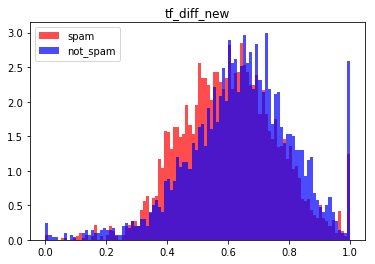

In [48]:
is_spam_data = [doc.features[8] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[8] for doc in train_docs if doc[1] == False]
# bins = range(0, 60, 1)
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('tf_diff_new')
plt.legend()
plt.show()

** Классификатор: **
Нужно реализовать

In [135]:
class Classifier:
    
    def __init__(self):
        self._freq = defaultdict(lambda:0)
        self._idf = defaultdict(lambda:0)

    def predict(self, doc):
        feats = doc.features[9]
        words_num = doc.features[5]
        tf = [f / words_num for f in feats.values()]
        if len(tf):
            idf = [log(self._n / (self._idf.get(feat, 0) + 1)) for feat in feats]
            tf_idf = sum(tf_i * idf[i] for i, tf_i in enumerate(tf)) / len(tf)
            idf_m = sum(idf) / len(tf)
        else:
            idf_m = 0
            tf_idf = 0
        return tf_idf, idf_m
    
    def predict_nb(self, doc):
        feats = doc.features[9]
        count_w = [w for w in feats.values()]
        x0 = [(self._freq.get((0, feat), 0) + 1) / (self._count[0] + self._v) for feat in feats]
        log_x0 = -log(self._classes[0]) + sum(-log(x_i) * count_w[i] for i, x_i in enumerate(x0))

        x1 = [(self._freq.get((1, feat), 0) + 1) / (self._count[1] + self._v) for feat in feats]
        log_x1 = -log(self._classes[1]) + sum(-log(x_i) * count_w[i] for i, x_i in enumerate(x1))

        prob1 = 1 / (1 + np.exp(log_x1 - log_x0)) #probability of spam
        return prob1

    def predict_all_nb(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict_nb(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    
    def fit_tf(self, t_docs):
        self._n += len(t_docs)
            
        for doc_num, doc in enumerate(t_docs): 
            freq_ = doc.features[9]
            for key, val in freq_.items():
                self._idf[key] += 1

            trace(doc_num)
#         self._idf_vec = [log(self._n / val) for val in self._idf.values()]
        trace(doc_num, 1)
    
    def train(self, docs):
        train_classes = [len([1 for doc in docs if doc[1] == False]),
                         len([1 for doc in docs if doc[1] == True])]
        self._classes = [0, 0]
        self._count = [0, 0]
        self._n = len(docs)
        
        for c in range(2):
            self._classes[c] = train_classes[c]
            self._classes[c] /= self._n
            
        for doc_num, doc in enumerate(docs): 
            mark = doc[1]
            freq_ = doc.features[9]
            for key, val in freq_.items():
                self._freq[mark, key] += val
                self._idf[key] += 1

            trace(doc_num)

        self._v = len(self._freq)
        for mark, feat in self._freq:
            self._count[mark] += 1

        trace(doc_num, 1)

In [136]:
# my_test_d = {'aa': 1, 'b':7, 'z': 5, 'kk':77}
# my_test_k = [k for k in my_test_d.keys()]
# my_test_v = [v for v in my_test_d.values()]

# print my_test_k, my_test_v

In [137]:
classifier = Classifier()
classifier.train(train_docs)

14:23:59 INFO:Complete items 00000
14:24:00 INFO:Complete items 01000
14:24:02 INFO:Complete items 02000
14:24:03 INFO:Complete items 03000
14:24:05 INFO:Complete items 04000
14:24:06 INFO:Complete items 05000
14:24:08 INFO:Complete items 06000
14:24:10 INFO:Complete items 07000
14:24:10 INFO:Complete items 07043


In [138]:
print classifier._freq[0, u'smile']

48


In [139]:
# Посмотреть, что предсказывается для тестового html
classifier.predict(DocItem(0, 0, test_url , test_features))

(0.825453375082259, 6.7255061688001145)

In [140]:
classifier.predict_nb(DocItem(0, 0, test_url , test_features))

0.010069247005488153

** Рисуем графики **

In [423]:
plot_results(train_docs, min_threshold=0, max_threshold=1, step=0.1, trace=1)

In [58]:
with open('nb_train_20191025.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all_nb(train_docs):
        prediction = item[3]
        writer.writerow([item[0], prediction])

11:38:24 INFO:Complete items 00000
11:38:27 INFO:Complete items 01000
11:38:29 INFO:Complete items 02000
11:38:31 INFO:Complete items 03000
11:38:34 INFO:Complete items 04000
11:38:37 INFO:Complete items 05000
11:38:39 INFO:Complete items 06000
11:38:42 INFO:Complete items 07000


In [59]:
# print item

(9222854048224216637, False, u'http://www.consultant.ru/law/hotdocs/11833.html', 1.324413186792272e-135)


In [60]:
with open('nb_train_20191025.csv', 'r') as input_file:
    headers = input_file.readline()
    train_nb = []

    for i, line in enumerate(input_file):
        parts = line.strip().split(',')
        url_id = int(parts[0])
        prediction = float(parts[1])
        train_nb.append([url_id, prediction])

In [61]:
# print train_nb[-1]

[9222854048224216637, 1.324413186792272e-135]


In [62]:
%%time

TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = list(load_csv_multiprocess(TEST_DATA_FILE, calc_features))

11:42:06 INFO:Complete items 00000 in worker_id 0
11:42:06 INFO:Complete items 00000 in worker_id 1
11:42:06 INFO:Complete items 00000 in worker_id 2
11:42:06 INFO:Complete items 00000 in worker_id 3
11:48:13 INFO:Complete items 01000 in worker_id 1
11:48:41 INFO:Complete items 01000 in worker_id 2
11:52:57 INFO:Complete items 02000 in worker_id 2
11:53:20 INFO:Complete items 02000 in worker_id 1
11:53:59 INFO:Complete items 01000 in worker_id 0
11:54:12 INFO:Complete items 01000 in worker_id 3
12:00:20 INFO:Complete items 03000 in worker_id 2
12:00:20 INFO:Complete items 03000 in worker_id 1
12:00:56 INFO:Complete items 02000 in worker_id 0
12:02:11 INFO:Complete items 02000 in worker_id 3
12:05:21 INFO:Complete items 04000 in worker_id 2
12:06:48 INFO:Complete items 04000 in worker_id 1
12:07:47 INFO:Complete items 03000 in worker_id 0
12:08:58 INFO:Complete items 03000 in worker_id 3
12:09:27 INFO:Complete items 05000 in worker_id 2
12:13:27 INFO:Complete items 05000 in worker_id 1


CPU times: user 11.3 s, sys: 4.03 s, total: 15.4 s
Wall time: 1h 50min 58s


In [63]:
# with open('test_features_new_tf_new_nb_20191025.csv' , 'w') as fout:
#     writer = csv.writer(fout, delimiter=str('\t'))
#     writer.writerow(['id', 'target', 'url', 'F_words_num', 'F_avg_word_len',
#                      'F_title_words_num', 'F_anchor_words_num',
#                      'F_compression_level_w', 'F_all_words_num',
#                      'F_tf_html_feat_m', 'F_tf_feat_m', 'F_tf_diff'])
#     for item in test_docs:
#         writer.writerow([item[0], item[1], item[2],
#                          item.features[0], item.features[1],
#                          item.features[2], item.features[3],
#                          item.features[4], item.features[5],
#                          item.features[6], item.features[7],
#                          item.features[8]])

In [82]:
# print test_docs[:2]

In [86]:
# DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

# with open('test_features_new_tf_new_nb_20191025.csv', 'r') as input_file:
#     headers = input_file.readline()
#     test_docs = []

#     for i, line in enumerate(input_file):
#         parts = line.strip().split('\t')
#         url_id = int(parts[0])
#         if parts[1] == 'True':
#             mark = True
#         else:
#             mark = False
#         url = parts[2]
#         words_num = int(parts[3])
#         avg_word_len = float(parts[4])
#         title_words_num = int(parts[5])
#         anchor_words_num = int(parts[6])
#         compression_level_w = float(parts[7])
#         all_words_num = int(parts[8])
#         tf_html_feat_m = float(parts[9])
#         tf_feat_m = float(parts[10])
#         tf_diff = float(parts[11])
#         features = [words_num, avg_word_len, title_words_num, anchor_words_num,
#                     compression_level_w, all_words_num, tf_html_feat_m, tf_feat_m,
#                     tf_diff]
         
#         test_docs.append(DocItem(url_id, mark, url, features))

In [87]:
# print test_docs[:2]

[DocItem(doc_id=-9216634615606576667, is_spam=True, url=u'http://petropavl.kz/whouse/autor/autor4.shtml', features=[408, 6.129901960784314, 13, 128, 0.3169392847241475, 549, 8.392064635174213, 1.90805991538333, 1.5238095238095237]), DocItem(doc_id=-9216796593526314243, is_spam=True, url=u'http://myachina9abbee.front.ru/allinone.html', features=[576, 5.855902777777778, 5, 72, 0.3709150326797386, 653, 11.840727370317483, 3.3634579173837116, 1.945945945945946])]


In [141]:
classifier.fit_tf(test_docs)

14:24:13 INFO:Complete items 00000
14:24:14 INFO:Complete items 01000
14:24:15 INFO:Complete items 02000
14:24:16 INFO:Complete items 03000
14:24:17 INFO:Complete items 04000
14:24:18 INFO:Complete items 05000
14:24:19 INFO:Complete items 06000
14:24:21 INFO:Complete items 07000
14:24:22 INFO:Complete items 08000
14:24:22 INFO:Complete items 09000
14:24:24 INFO:Complete items 10000
14:24:25 INFO:Complete items 11000
14:24:26 INFO:Complete items 12000
14:24:27 INFO:Complete items 13000
14:24:28 INFO:Complete items 14000
14:24:29 INFO:Complete items 15000
14:24:30 INFO:Complete items 16000
14:24:30 INFO:Complete items 16038


In [66]:
# with open('freq_vocab_20191025.csv' , 'wb') as fout:
#     writer = csv.writer(fout, delimiter=str('\t'))
#     writer.writerow(['Mark','word', 'freq'])
#     for item in classifier._freq:
#         mark = item[0]
#         word = item[1]
#         writer.writerow([mark, word.encode('utf-8'), classifier._freq[item]])

In [67]:
# with open('idf_vocab_20191025.csv' , 'wb') as fout:
#     writer = csv.writer(fout, delimiter=str('\t'))
#     writer.writerow(['word', 'freq'])
#     for key, val in classifier._idf.items():
#         writer.writerow([key.encode('utf-8'), val])

In [68]:
# with open('train_vocab_20191025.csv' , 'wb') as fout:
#     writer = csv.writer(fout, delimiter=str('\t'))
#     writer.writerow(['id', 'Mark','word', 'freq'])
#     for item in train_docs:
#         word_vocab = item.features[9]
#         for key, val in word_vocab.items():
#             writer.writerow([item[0], item[1], key.encode('utf-8'), val])

In [69]:
# with open('test_vocab_20191024.csv' , 'wb') as fout:
#     writer = csv.writer(fout, delimiter=str('\t'))
#     writer.writerow(['id', 'Mark','word', 'freq'])
#     for item in test_docs:
#         word_vocab = item.features[9]
#         for key, val in word_vocab.items():
#             writer.writerow([item[0], item[1], key.encode('utf-8'), val])

In [70]:
with open('tf_idf_train_20191025.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','tf_idf_mean', 'idf_mean'])
    for item in classifier.predict_all(train_docs):
        writer.writerow([item[0], item[3][0], item[3][1]])

13:34:52 INFO:Complete items 00000
13:34:54 INFO:Complete items 01000
13:34:55 INFO:Complete items 02000
13:34:57 INFO:Complete items 03000
13:34:58 INFO:Complete items 04000
13:34:59 INFO:Complete items 05000
13:35:01 INFO:Complete items 06000
13:35:02 INFO:Complete items 07000


In [71]:
# print item

In [72]:
with open('tf_idf_train_20191025.csv', 'r') as input_file:
    headers = input_file.readline()
    train_tf_idf = []

    for i, line in enumerate(input_file):
        parts = line.strip().split(',')
        url_id = int(parts[0])
        tf_idf = float(parts[1])
        idf = float(parts[2])
        train_tf_idf.append([url_id, tf_idf, idf])

In [73]:
print train_tf_idf[-1]

[9222854048224216637, 0.012762169066197327, 2.952810851085982]


In [74]:
with open('tf_idf_test_20191025.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','tf_idf_mean', 'idf_mean'])
    for item in classifier.predict_all(test_docs):
        writer.writerow([item[0], item[3][0], item[3][1]])

13:35:02 INFO:Complete items 00000
13:35:04 INFO:Complete items 01000
13:35:05 INFO:Complete items 02000
13:35:07 INFO:Complete items 03000
13:35:08 INFO:Complete items 04000
13:35:10 INFO:Complete items 05000
13:35:11 INFO:Complete items 06000
13:35:12 INFO:Complete items 07000
13:35:14 INFO:Complete items 08000
13:35:15 INFO:Complete items 09000
13:35:17 INFO:Complete items 10000
13:35:19 INFO:Complete items 11000
13:35:20 INFO:Complete items 12000
13:35:22 INFO:Complete items 13000
13:35:23 INFO:Complete items 14000
13:35:25 INFO:Complete items 15000
13:35:26 INFO:Complete items 16000


In [75]:
# print item

In [76]:
with open('tf_idf_test_20191025.csv', 'r') as input_file:
    headers = input_file.readline()
    test_tf_idf = []

    for i, line in enumerate(input_file):
        parts = line.strip().split(',')
        url_id = int(parts[0])
        tf_idf = float(parts[1])
        idf = float(parts[2])
        test_tf_idf.append([url_id, tf_idf, idf])

In [77]:
print test_tf_idf[-1]

[9220928100490675079, 0.005160573171626474, 3.2474077185972914]


In [78]:
with open('nb_test_20191025.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all_nb(test_docs):
        prediction = item[3]
        writer.writerow([item[0], prediction])

13:35:27 INFO:Complete items 00000
13:35:30 INFO:Complete items 01000
13:35:34 INFO:Complete items 02000
13:35:37 INFO:Complete items 03000
13:35:40 INFO:Complete items 04000
13:35:42 INFO:Complete items 05000
13:35:45 INFO:Complete items 06000
13:35:48 INFO:Complete items 07000
13:35:51 INFO:Complete items 08000
13:35:54 INFO:Complete items 09000
13:35:57 INFO:Complete items 10000
13:36:01 INFO:Complete items 11000
13:36:03 INFO:Complete items 12000
13:36:06 INFO:Complete items 13000
13:36:09 INFO:Complete items 14000
13:36:12 INFO:Complete items 15000
13:36:14 INFO:Complete items 16000


In [79]:
# print item

In [80]:
with open('nb_test_20191025.csv', 'r') as input_file:
    headers = input_file.readline()
    test_nb = []

    for i, line in enumerate(input_file):
        parts = line.strip().split(',')
        url_id = int(parts[0])
        prediction = float(parts[1])
        test_nb.append([url_id, prediction])

In [81]:
print test_nb[-1]

[9220928100490675079, 1.5723538679062534e-93]


In [89]:
from scipy.stats import randint as randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# [0 - words_num, 1 - avg_word_len, 2 - title_words_num,
#  3 - anchor_words_num, 4 - compression_level_w,
#  5 - all_words_num, 6 - tf_html_feat_m, 7 - tf_feat_m,
#  8 - tf_diff, 9 - nb, 10 - tf_idf, 11 - idf]

In [110]:
y_train = []
X_train = []

for i, item in enumerate(train_docs):
    feat = [f for f in item.features[:9]]
    if feat[8] != 0:
        feat[8] = 1 / feat[8]
    feat.append(train_nb[i][1])
    feat.append(train_tf_idf[i][1])
    feat.append(train_tf_idf[i][2])
    X_train.append(feat)
    y_train.append(int(item.is_spam))

X_train = np.array(X_train)
y_train = np.array(y_train)
    
print X_train[:3]
print y_train[:3]

[[4.93000000e+002 7.57606491e+000 1.00000000e+000 1.50000000e+002
  2.55909455e-001 6.44000000e+002 5.71301892e+000 2.15003291e+000
  1.15384615e+000 5.62862838e-199 8.99931198e-003 4.52838960e+000]
 [7.16000000e+002 5.90083799e+000 3.00000000e+000 1.05000000e+002
  2.34472620e-001 8.24000000e+002 8.05623554e+000 2.52000000e+000
  1.40000000e+000 6.51876975e-206 5.30236544e-003 3.12813897e+000]
 [6.63000000e+002 6.50527903e+000 5.00000000e+000 3.40000000e+002
  1.97166311e-001 1.00800000e+003 1.67311360e+001 5.20068259e+000
  1.28787879e+000 0.00000000e+000 6.15756023e-003 3.72165852e+000]]
[0 0 0]


In [111]:
y_test = []
X_test = []

for i, item in enumerate(test_docs):
    feat = [f for f in item.features[:9]]
    if feat[8] != 0:
        feat[8] = 1 / feat[8]
    feat.append(test_nb[i][1])
    feat.append(test_tf_idf[i][1])
    feat.append(test_tf_idf[i][2])
    X_test.append(feat)

X_test = np.array(X_test)
y_test = np.array(y_test)
    
print X_test[:3]
print y_test[:3]

[[4.01000000e+002 6.17206983e+000 1.30000000e+001 1.24000000e+002
  3.16939285e-001 5.38000000e+002 8.81434352e+000 3.31133089e+000
  1.53086420e+000 2.37821745e-158 6.83490085e-003 2.78878758e+000]
 [5.52000000e+002 6.00362319e+000 5.00000000e+000 6.00000000e+001
  3.70915033e-001 6.17000000e+002 1.18845379e+001 5.57831938e+000
  1.76470588e+000 1.09048905e-006 4.84479215e-003 2.46432437e+000]
 [5.54000000e+002 6.26353791e+000 8.00000000e+000 6.90000000e+001
  3.37165418e-001 6.31000000e+002 2.02742898e+001 1.23652583e+001
  1.40816327e+000 3.32273142e-038 6.12460175e-003 3.22656369e+000]]
[]


In [104]:
param_grid = {
    'max_depth': randint(15, 30),
    #     'criterion': ['gini', 'entropy']
#     'max_features': [1, 2, 3, 4, 5, 6]
    'min_samples_split': randint(2, 5)}


cv = KFold(n_splits=5, random_state=123, shuffle=True)

model_RF = RandomForestClassifier(random_state=123,
                                  n_estimators=100,
                                  n_jobs=-1)


random_search = RandomizedSearchCV(model_RF, param_distributions=param_grid,
                                   n_iter=100, n_jobs=-1, cv=cv,
                                   scoring='f1', random_state=123)



random_search.fit(X_train, y_train)

print(random_search.best_params_)
print(random_search.best_score_)

{u'min_samples_split': 2, u'max_depth': 20}
0.9644401317457912


In [105]:
f1_score(y_pred=random_search.predict(X_train), y_true=y_train, average='macro')

0.9998539861743314

In [106]:
# {u'min_samples_split': 3, u'n_estimators': 920, u'max_depth': 22}
# 0.965481952685975
# {u'min_samples_split': 2, u'n_estimators': 500, u'max_depth': 17}
# 0.9651327950914868
# {u'min_samples_split': 2, u'max_depth': 21}
# 0.9652913441901149
# {u'min_samples_split': 3, u'max_depth': 15}
# 0.9649806018299371
# {u'min_samples_split': 2, u'max_depth': 20}
# 0.9644401317457912

In [107]:
best_model = random_search.best_estimator_
y_test = best_model.predict(X_test)

In [108]:
best_model.feature_importances_

array([0.05801316, 0.06357621, 0.01992376, 0.05150209, 0.13519805,
       0.03416491, 0.08131722, 0.04707724, 0.02888962, 0.39301967,
       0.05388154, 0.03343654])

In [ ]:
# [0 - words_num, 1 - avg_word_len, 2 - title_words_num,
#  3 - anchor_words_num, 4 - compression_level_w,
#  5 - all_words_num, 6 - tf_html_feat_m, 7 - tf_feat_m,
#  8 - tf_diff, 9 - nb, 10 - tf_idf, 11 - idf]

In [109]:
with open('choose_sub_file_name.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for i, y in enumerate(y_test):
        doc_id = test_docs[i][0]
        prediction = y
        writer.writerow([doc_id, prediction])